## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [5]:
import os
import shutil
import glob

## Arguments & Initializations

In [6]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [7]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [8]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [9]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia2"

In [10]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

cpp_metrics = defaultdict(list) 
cpp_mia_metrics = defaultdict(list)

pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [11]:
ATTACK

'mia2'

## Loading & Splitting Dataset

In [12]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [13]:
dataset_orig.features.shape

(20798, 13)

In [14]:
privileged_groups

[{'gender': 1}]

In [15]:
sens_attr

'gender'

In [16]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [17]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [18]:
seed = 1234
np.random.seed(seed)

In [19]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [20]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
#     print("==============================================================")
#     print("GET UNIQUE INDICES REFERENCE")
#     print(f"Number of train points: {len(train_index)}")
#     print(f"Number of test points: {len(test_index)}")
#     print(f"Number of population points: {len(population_index)}")
#     print("==============================================================")
    
    return train_index, test_index, population_index

In [21]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [22]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [23]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [24]:
target_dataset = None
reference_dataset = None

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

#         print("#### Train dataset's features are as below:")
#         print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
#     else:
#         print('no bias type specified')

#     # show data info
#     print("#### Training Dataset shape")
#     print(dataset_orig_train.features.shape)
#     print("#### Favorable and unfavorable labels")
#     print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
#     print("#### Protected attribute names")
#     print(dataset_orig_train.protected_attribute_names)
#     print("#### Privileged and unprivileged protected groups")
#     print(privileged_groups, unprivileged_groups)
#     print("#### Privileged and unprivileged protected attribute values")
#     print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
#     print("#### Dataset feature names")
#     print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

#     print("#### Train shape, validation shape, test shape")
#     print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  1414.0 1081.0
base_pos unpriv:  0.9343200740055504
base_pos priv:  0.9582743988684582
number of favorable labels:  2365
Difference in mean outcomes between unprivileged and privileged groups = -0.023954
#######################################################################
                    dt
#######################################################################

------------------------------

[INFO] Original Results......

------------------------------

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_

DATAFRAME BEFORE DIR TRANSFORM        decile3   decile1     race   cluster      lsat      ugpa    dob_yr  \
0     0.014110  0.056440  0.00000  0.042330  0.486792  0.043741  0.860705   
1     0.102407  0.102407  0.00000  0.012801  0.448030  0.047363  0.870459   
2     0.044419  0.044419  0.00000  0.044419  0.666289  0.031094  0.725515   
3     0.107822  0.095841  0.01198  0.047921  0.539108  0.045525  0.814652   
4     0.089966  0.051409  0.00000  0.025704  0.436976  0.038557  0.886804   
...        ...       ...      ...       ...       ...       ...       ...   
2490  0.089194  0.114678  0.00000  0.038226  0.433226  0.044597  0.879195   
2491  0.100701  0.113288  0.00000  0.012588  0.516091  0.040280  0.830781   
2492  0.012748  0.025496  0.00000  0.012748  0.497179  0.040794  0.854128   
2493  0.060917  0.073101  0.00000  0.048734  0.548255  0.040205  0.816291   
2494  0.013460  0.013460  0.01346  0.013460  0.356689  0.039034  0.928737   

      fulltime   fam_inc  gender      tier  

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['rew_log_pop']
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.63      0.29      0.40       130
         1.0       0.96      0.99      0.98      2365

    accuracy                           0.95      2495
   macro avg       0.80      0.64      0.69      2495
weighted avg       0.95      0.95      0.95      2495

Train accuracy:  0.9543086172344689
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [0.29983635]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: [0.00867832]
)
MIA_Result(
  Name: subpopulation_0.0_label_

Results are stored in: ['cpp_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.67      0.28      0.40       130
         1.0       0.96      0.99      0.98      2365

    accuracy                           0.96      2495
   macro avg       0.82      0.64      0.69      2495
weighted avg       0.95      0.96      0.95      2495

Train accuracy:  0.9555110220440882
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.50
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 71, Test = 68
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy:

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_1.0_label_

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        decile3   decile1  race   cluster      lsat      ugpa    dob_yr  \
0     0.064252  0.064252   0.0  0.048189  0.465826  0.059433  0.867400   
1     0.050830  0.025415   0.0  0.012708  0.457473  0.039394  0.876824   
2     0.013687  0.027374   0.0  0.041062  0.437991  0.045168  0.889669   
3     0.076667  0.076667   0.0  0.012778  0.460003  0.047278  0.868894   
4     0.120631  0.120631   0.0  0.012063  0.506651  0.043427  0.832355   
...        ...       ...   ...       ...       ...       ...       ...   
2490  0.063671  0.089140   0.0  0.038203  0.509371  0.047117  0.840462   
2491  0.050681  0.063351   0.0  0.025340  0.481466  0.040545  0.861572   
2492  0.096803  0.084703   0.0  0.060502  0.508217  0.044771  0.834927   
2493  0.037120  0.037120   0.0  0.012373  0.519678  0.032171  0.841383   
2494  0.052918  0.052918   0.0  0.039689  0.410117  0.044981  0.899613   

      fulltime   fam_inc  gende

Best thresh:  [0.19883775]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.19883775]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.29
  Positive predictive value: 0.80
  Optimal thershold: [1.33663714]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: [0.08873926]
)
MIA_Result(
  Name: subpopulation_1.0_l

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_1.0_label_

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        decile3   decile1  race   cluster      lsat      ugpa    dob_yr  \
0     0.064252  0.064252   0.0  0.048189  0.465826  0.059433  0.867400   
1     0.050830  0.025415   0.0  0.012708  0.457473  0.039394  0.876824   
2     0.013687  0.027374   0.0  0.041062  0.437991  0.045168  0.889669   
3     0.076667  0.076667   0.0  0.012778  0.460003  0.047278  0.868894   
4     0.120631  0.120631   0.0  0.012063  0.506651  0.043427  0.832355   
...        ...       ...   ...       ...       ...       ...       ...   
2490  0.063671  0.089140   0.0  0.038203  0.509371  0.047117  0.840462   
2491  0.050681  0.063351   0.0  0.025340  0.481466  0.040545  0.861572   
2492  0.096803  0.084703   0.0  0.060502  0.508217  0.044771  0.834927   
2493  0.037120  0.037120   0.0  0.012373  0.519678  0.032171  0.841383   
2494  0.052918  0.052918   0.0  0.039689  0.410117  0.044981  0.899613   

      fulltime   fam_inc  gende

Best thresh:  [0.19883775]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.19883775]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.29
  Positive predictive value: 0.80
  Optimal thershold: [1.33663714]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: [0.08873926]
)
MIA_Result(
  Name: subpopulation_1.0_l

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_1.0_label_

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        decile3   decile1  race   cluster      lsat      ugpa    dob_yr  \
0     0.064252  0.064252   0.0  0.048189  0.465826  0.059433  0.867400   
1     0.050830  0.025415   0.0  0.012708  0.457473  0.039394  0.876824   
2     0.013687  0.027374   0.0  0.041062  0.437991  0.045168  0.889669   
3     0.076667  0.076667   0.0  0.012778  0.460003  0.047278  0.868894   
4     0.120631  0.120631   0.0  0.012063  0.506651  0.043427  0.832355   
...        ...       ...   ...       ...       ...       ...       ...   
2490  0.063671  0.089140   0.0  0.038203  0.509371  0.047117  0.840462   
2491  0.050681  0.063351   0.0  0.025340  0.481466  0.040545  0.861572   
2492  0.096803  0.084703   0.0  0.060502  0.508217  0.044771  0.834927   
2493  0.037120  0.037120   0.0  0.012373  0.519678  0.032171  0.841383   
2494  0.052918  0.052918   0.0  0.039689  0.410117  0.044981  0.899613   

      fulltime   fam_inc  gende

Best thresh:  [0.19883775]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.19883775]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.29
  Positive predictive value: 0.80
  Optimal thershold: [1.33663714]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: [0.08873926]
)
MIA_Result(
  Name: subpopulation_1.0_l

TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name:

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_1.0_label_

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        decile3   decile1  race   cluster      lsat      ugpa    dob_yr  \
0     0.064252  0.064252   0.0  0.048189  0.465826  0.059433  0.867400   
1     0.050830  0.025415   0.0  0.012708  0.457473  0.039394  0.876824   
2     0.013687  0.027374   0.0  0.041062  0.437991  0.045168  0.889669   
3     0.076667  0.076667   0.0  0.012778  0.460003  0.047278  0.868894   
4     0.120631  0.120631   0.0  0.012063  0.506651  0.043427  0.832355   
...        ...       ...   ...       ...       ...       ...       ...   
2490  0.063671  0.089140   0.0  0.038203  0.509371  0.047117  0.840462   
2491  0.050681  0.063351   0.0  0.025340  0.481466  0.040545  0.861572   
2492  0.096803  0.084703   0.0  0.060502  0.508217  0.044771  0.834927   
2493  0.037120  0.037120   0.0  0.012373  0.519678  0.032171  0.841383   
2494  0.052918  0.052918   0.0  0.039689  0.410117  0.044981  0.899613   

      fulltime   fam_inc  gende

Best thresh:  [0.19883775]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.19883775]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.29
  Positive predictive value: 0.80
  Optimal thershold: [1.33663714]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: [0.08873926]
)
MIA_Result(
  Name: subpopulation_1.0_l

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name:

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

LOSS:  [0.04413013 0.04413013 0.04413013 0.04413013 0.04413013]
Results are stored in: ['cpp_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
  Positive predictive value: 0.45
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.00
  Positive predictive value: 0.51
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_1.0_label_

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM        decile3   decile1  race   cluster      lsat      ugpa    dob_yr  \
0     0.064252  0.064252   0.0  0.048189  0.465826  0.059433  0.867400   
1     0.050830  0.025415   0.0  0.012708  0.457473  0.039394  0.876824   
2     0.013687  0.027374   0.0  0.041062  0.437991  0.045168  0.889669   
3     0.076667  0.076667   0.0  0.012778  0.460003  0.047278  0.868894   
4     0.120631  0.120631   0.0  0.012063  0.506651  0.043427  0.832355   
...        ...       ...   ...       ...       ...       ...       ...   
2490  0.063671  0.089140   0.0  0.038203  0.509371  0.047117  0.840462   
2491  0.050681  0.063351   0.0  0.025340  0.481466  0.040545  0.861572   
2492  0.096803  0.084703   0.0  0.060502  0.508217  0.044771  0.834927   
2493  0.037120  0.037120   0.0  0.012373  0.519678  0.032171  0.841383   
2494  0.052918  0.052918   0.0  0.039689  0.410117  0.044981  0.899613   

      fulltime   fam_inc  gende

Best thresh:  [0.19883775]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.19883775]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.29
  Positive predictive value: 0.80
  Optimal thershold: [1.33663714]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: [0.08873926]
)
MIA_Result(
  Name: subpopulation_1.0_l

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
 

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

Results are stored in: ['cpp_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

LOSS:  [0.04413013 0.04413013 0.04413013 0.04413013 0.04413013]
Results are stored in: ['cpp_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.00
 

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.68      0.38      0.48       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.82      0.68      0.73      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9607214428857715
Validating Original ...

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

Best thresh:  [-9.99e-05]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.37
  Positive predictive value: 0.63
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: [0.05374428]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.67
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.41
  Positive predictive value: 0.62
  Optimal thershold: [2.30258509]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 1043, Test = 1004
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_1.0_labe

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.65      0.42      0.51       122
         1.0       0.97      0.99      0.98      2373

    accuracy                           0.96      2495
   macro avg       0.81      0.70      0.74      2495
weighted avg       0.95      0.96      0.96      2495

Train accuracy:  0.9603206412825651
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  [-9.99e-05]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2495, Test = 2495
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: [0.04413013]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 65, Test = 78
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.00
  T

In [27]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [ ]:
df_bank['gender'].value_counts()

In [ ]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
y_counts = df_bank['y'].value_counts()

In [ ]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [77]:
df_bank.shape

(20798, 14)

## Display Output

In [28]:
priv_metric_orig_copy = priv_metric_orig

In [29]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 27767.0, 'total_unpriv': 22133.0})

In [30]:
priv_metric_orig

defaultdict(float, {'total_priv': 27767.0, 'total_unpriv': 22133.0})

In [31]:
priv_metric_orig.items()

dict_items([('total_priv', 27767.0), ('total_unpriv', 22133.0)])

In [32]:
priv_metric_orig = priv_metric_orig_copy

In [33]:
orig_metrics.items()

dict_items([('bal_acc', [0.507329283715688, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084]), ('avg_odds_diff', [0.017147590435922178, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194]), ('disp_imp', [0.00288392213410249, 0.006348779126607473, 0.006348779126607473, 0.0063487791266

In [34]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_sex
2495
2)

              total_priv  total_unpriv
num_instance                          
orig             1388.35       1106.65
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.950942       0.049058    0.958873      0.041127      0.940985   
transf      0.958863       0.041137    0.958873      0.041127      0.958855   

         unpriv_unfavor  
dataset                  
orig           0.059015  
transf         0.041145  


In [35]:
orig_metrics.items()

dict_items([('bal_acc', [0.507329283715688, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084, 0.5283418426549084]), ('avg_odds_diff', [0.017147590435922178, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194, -0.015523051841523194]), ('disp_imp', [0.00288392213410249, 0.006348779126607473, 0.006348779126607473, 0.0063487791266

In [36]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

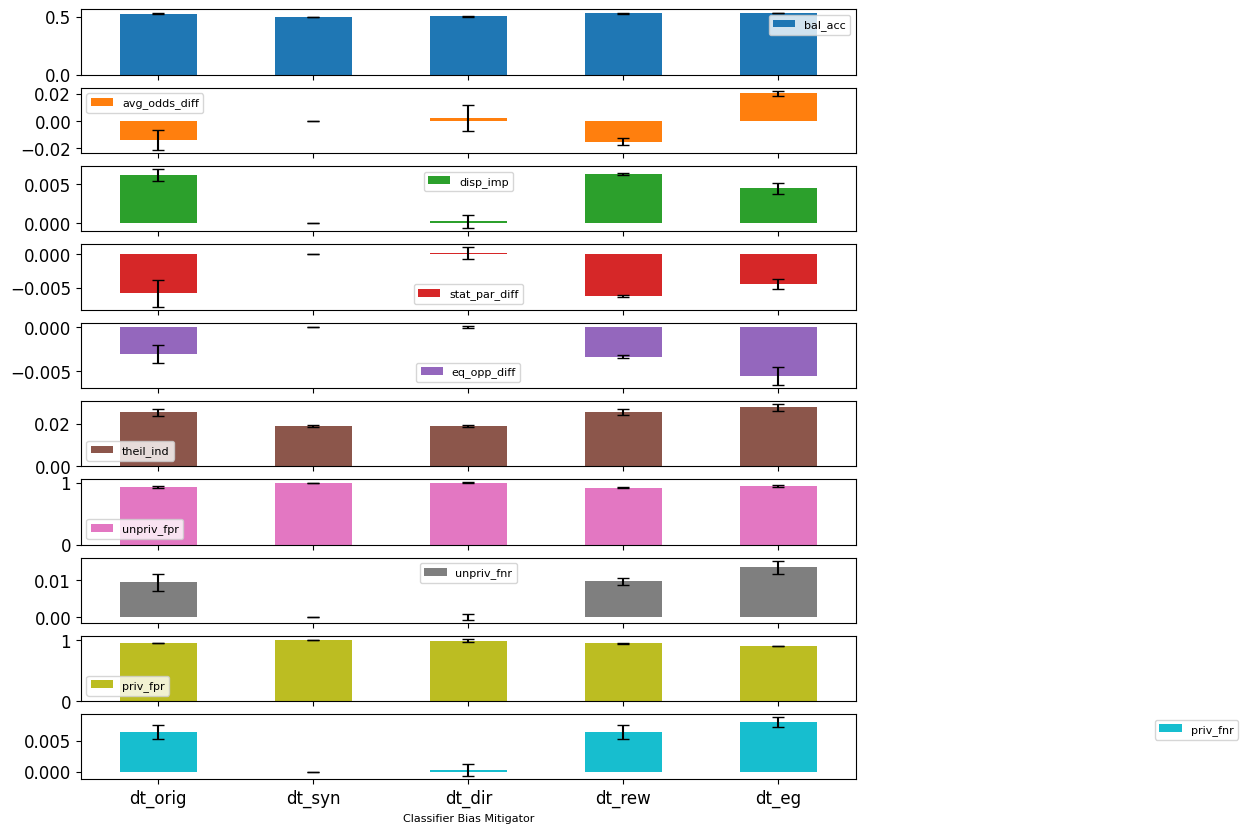

In [37]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [38]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [39]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,
orig,0.512725,0.711464,0.516175,0.743128,0.513081
syn,0.512365,0.686906,0.516702,0.664425,0.504315
dir,0.519018,0.705543,0.516061,0.686841,0.523018
rew,0.513607,0.651548,0.515571,0.727813,0.513050
eg,0.519389,0.705282,0.522831,0.742593,0.516852


In [40]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [41]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [42]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.711464,0.516175,0.743128,0.513081
syn,0.686906,0.516702,0.664425,0.504315
dir,0.705543,0.516061,0.686841,0.523018
rew,0.651548,0.515571,0.727813,0.513050
eg,0.705282,0.522831,0.742593,0.516852


<Axes: xlabel='Classifier MIA Attacks'>

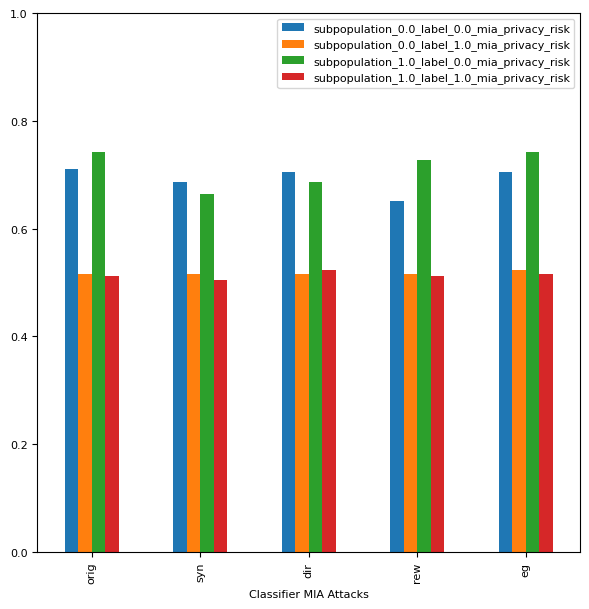

In [43]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [44]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.711464  0.686906  0.705543  0.651548  0.705282
subpopulation_0.0_label_1.0_mia_privacy_risk  0.516175  0.516702  0.516061  0.515571  0.522831
subpopulation_1.0_label_0.0_mia_privacy_risk  0.743128  0.664425  0.686841  0.727813  0.742593
subpopulation_1.0_label_1.0_mia_privacy_risk  0.513081  0.504315  0.523018  0.51305   0.516852


### Visualizing using novel technique

In [47]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


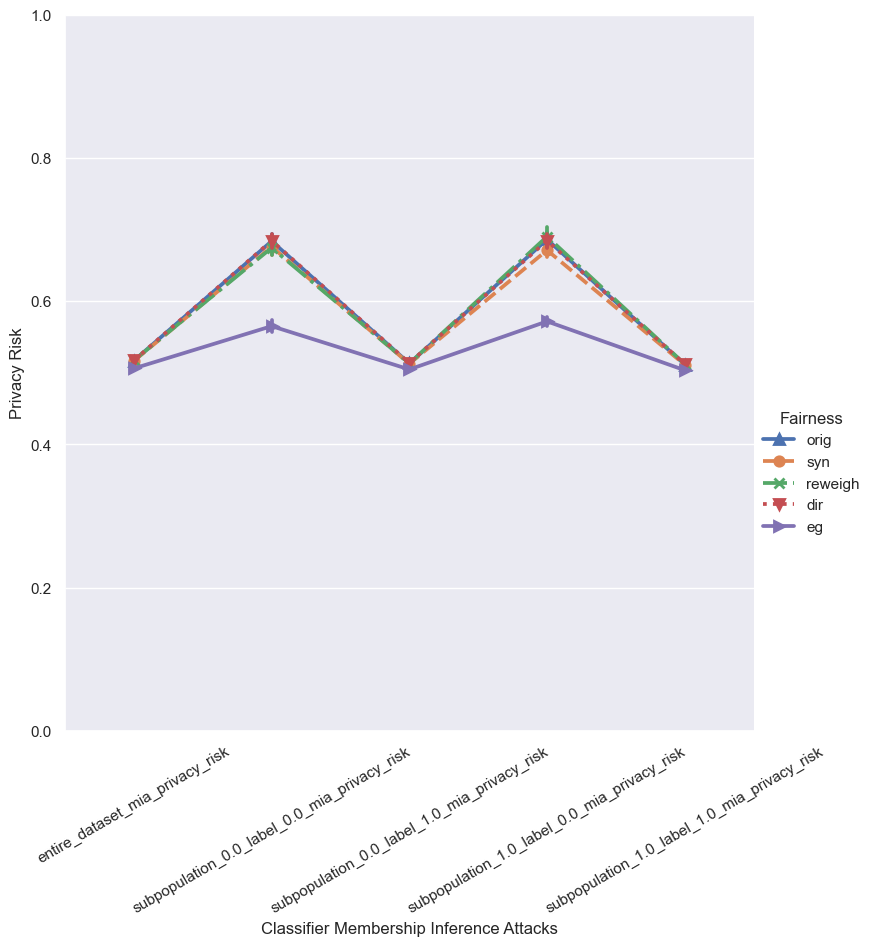

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr